# Noise2Self-inspired Optopatch denoising

In [1]:
%matplotlib inline

import os
import sys
notebook_path = os.path.abspath('.')
sources_path = os.path.abspath(os.path.join(notebook_path, '..'))
sys.path.insert(0, sources_path)

import matplotlib.pylab as plt
import numpy as np
from time import time
import torch
import logging
import json
import pprint
import pickle

from typing import List

import neptune.new as neptune
from tqdm.notebook import tqdm, trange

from cellmincer.opto_ws import OptopatchBaseWorkspace, OptopatchDenoisingWorkspace

from cellmincer.opto_features import OptopatchGlobalFeatureContainer

from cellmincer.opto_utils import \
    crop_center, \
    get_nn_spatio_temporal_mean, \
    get_nn_spatial_mean

from cellmincer.opto_denoise import \
    get_minimum_spatial_padding, \
    generate_occluded_training_data, \
    get_noise2self_loss, \
    generate_input_for_single_frame_denoising, \
    denoise_single_frame

from cellmincer.opto_models import \
    ConditionalUNet, \
    TemporalDenoiser, \
    activation_from_str


device = torch.device("cuda")
dtype = torch.float32

def new_fig(figsize=(15, 5)):
    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    return fig, ax

logger = logging.getLogger()

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

# run = neptune.init(project='brice/cellmincer', api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiNGMwZTE4YTUtOTMyNC00YWQxLTgyM2MtNmQ4NGFjMzM4MDQyIn0=')

In [2]:
from contextlib import contextmanager

@contextmanager
def evaluating(net):
    '''Temporarily switch to evaluation mode.'''
    istrain = net.training
    try:
        net.eval()
        yield net
    finally:
        if istrain:
            net.train()
    
###############################################################################################
# TODO
# this method needs major improvement
# currently, to denoise each frame, `t_order` frames are processed
# this leads to significant redundancy in calculations since in principle,
# the U-Net needs to operate on every frame only once
#
# the better implementation must first process each frame with `spatial_unet_processor`,
# perhaps in large batches and keep the results in GPU memory. then we run `temporal_denoiser`
# on rolling windows.
###############################################################################################

def generate_denoised_movie(
        ws_denoising_list: List[OptopatchBaseWorkspace],
        spatial_unet_processor: List[OptopatchDenoisingWorkspace],
        temporal_denoiser: torch.nn.Module,
        i_dataset: int,
        i_t_begin: int,
        i_t_end: int,
        x0: int,
        y0: int,
        x_window: int,
        y_window: int):
    

    denoised_movie_txy = np.zeros(
        (i_t_end - i_t_begin, ws_denoising_list[0].width, ws_denoising_list[0].height),
        dtype=np.float32)

    with evaluating(spatial_unet_processor):
        with evaluating(temporal_denoiser):
            
            for i_t in range(i_t_begin, i_t_end):

                denoising_input_data = generate_input_for_single_frame_denoising(
                    ws_denoising_list=ws_denoising_list,
                    i_dataset=i_dataset,
                    i_t=i_t,
                    t_order=denoiser_config['t_order'],
                    x0=x0,
                    y0=y0,
                    x_window=x_window,
                    y_window=y_window,
                    device=device,
                    dtype=dtype)

                output = denoise_single_frame(
                    denoising_input_data,
                    ws_denoising_list=ws_denoising_list,
                    spatial_unet_processor=spatial_unet_processor,
                    temporal_denoiser=temporal_denoiser)                
                temporal_endpoint_xy = output['temporal_endpoint_xy']

                denoised_movie_txy[
                    i_t - i_t_begin,
                    x0:(x0 + x_window),
                    y0:(y0 + y_window)] = temporal_endpoint_xy.cpu().numpy()

        return denoised_movie_txy


def get_denoised_movie_sma_txy(denoised_movie_txy_list):
    n_movies = len(denoised_movie_txy_list)
    denoised_movie_sma_txy = denoised_movie_txy_list[0].copy() / n_movies
    for denoised_movie_txy in denoised_movie_txy_list[1:]:
        denoised_movie_sma_txy += (denoised_movie_txy / n_movies)
    return denoised_movie_sma_txy


def save_model_state(model_dir, model_prefix, index, save_adam_state=True, save_rng_state=True):
    full_model_prefix = f'{model_prefix}__{index:06d}'
    with open(os.path.join(model_dir, f'denoiser_config__{full_model_prefix}.json'), 'w') as f:
        json.dump(denoiser_config, f)
    torch.save(
        spatial_unet_processor.state_dict(),
        os.path.join(model_dir, f'spatial_unet_processor__{full_model_prefix}.pt'))
    torch.save(
        temporal_denoiser.state_dict(),
        os.path.join(model_dir, f'temporal_denoiser__{full_model_prefix}.pt'))
    if save_adam_state:
        torch.save(
            optim.state_dict(),
            os.path.join(model_dir, f'adam_state__{full_model_prefix}.pt'))
    if save_rng_state:
        torch.save(
            torch.get_rng_state(),
            os.path.join(model_dir, f'rng_state__{full_model_prefix}.pt'))
#     if neptune_upload:
#         run['model/spatial_unet'].upload(spatial_unet_processor.state_dict())
#         run['model/temporal'].upload(temporal_denoiser.state_dict())


def load_model_state(model_dir, model_prefix, index):
    spatial_unet_processor_state = \
        torch.load(os.path.join(
            model_dir, f'spatial_unet_processor__{model_prefix}__{index:06d}.pt'))
    temporal_denoiser_state = \
        torch.load(os.path.join(
            model_dir, f'temporal_denoiser__{model_prefix}__{index:06d}.pt'))
    try:
        adam_state = torch.load(os.path.join(
            model_dir, f'adam_state__{model_prefix}__{index:06d}.pt'))
    except:
        adam_state = None
    try:
        torch.set_rng_state(torch.load(os.path.join(
            model_dir, f'rng_state__{model_prefix}__{index:06d}.pt')))
    except:
        pass
    return {
        'spatial_unet_processor_state': spatial_unet_processor_state,
        'temporal_denoiser_state': temporal_denoiser_state,
        'adam_state': adam_state}


def get_swa_state_dict(model_dir, model_prefix, begin_index, end_index):
    first_state = load_model_state(model_dir, model_prefix, begin_index)
    keys = list(first_state.keys())

    ave_state = first_state
    n_summed = 1
    for index in range(begin_index + 1, end_index):
        try:
            c_state = load_model_state(model_dir, model_prefix, index)
        except:
            continue
            
        for key in keys:
            ave_state[key] += c_state[key]

        n_summed += 1

    for key in keys:
        ave_state[key] /= n_summed
        
    return ave_state


def smooth_list(values, smoothing_window):
    if len(values) < smoothing_window:
        return np.mean(values)
    else:
        return np.mean(values[-smoothing_window:])

## Configuration

In [3]:
data_source = 'optosynth'

if data_source == 'optosynth':
    data_dir = '/home/jupyter/bw-data/Optosynth/'
    
#     optosynth_runs = [(1, 5, 50), (2, 5, 50), (3, 5, 50), (4, 5, 50), (5, 5, 50)]
#     optosynth_runs = [(1, 10, 200), (2, 10, 200), (3, 10, 200), (4, 10, 200), (5, 10, 200)]
#     optosynth_runs = [(1, 20, 10), (2, 20, 10), (3, 20, 10), (4, 20, 10), (5, 20, 10)]
    optosynth_runs = [(1, 20, 50), (2, 20, 50), (3, 20, 50), (4, 20, 50), (5, 20, 50)][:1]

    opto_mov_prefixes = [f'optosynth_first_wave__{trial}__{neurons}__{noise}'
        for trial, neurons, noise in optosynth_runs
    ]

elif data_source == 'sami':
    data_dir = '/home/jupyter/bw-data/Optopatch/'

    opto_mov_prefixes = [
        'D1_FOV3_W2_at135105',
        'D4_FOV2_W2_at171603',
        'D4_FOV3_W2_at172029',
        'E3_FOV1_W2_at155440',
        'F1_FOV2_W1_at143005'
    ]

# run['train/datasets'] = opto_mov_prefixes

opto_diff_mov_path_list = [
    os.path.join(data_dir, f'preproc-data/{prefix}_trend_subtracted.npy')
    for prefix in opto_mov_prefixes
]

opto_bg_mov_path_list = [
    os.path.join(data_dir, f'preproc-data/{prefix}_trend.npy')
    for prefix in opto_mov_prefixes
]

opto_noise_params_path_list = [
    os.path.join(data_dir, f'preproc-data/{prefix}_noise_params.json')
    for prefix in opto_mov_prefixes
]

opto_feature_path_list = [
    os.path.join(data_dir, f'preproc-feature-data/{prefix}__features.pkl')
    for prefix in opto_mov_prefixes
]

n_datasets = len(opto_mov_prefixes)

# output
output_path = os.path.join(data_dir, f'denoised-data')
model_root = '/home/jupyter/bw-code/CellMincer/saved-models-new/cellmincer'

if not os.path.exists(output_path):
    os.mkdir(output_path)
    
if not os.path.exists(model_root):
    os.mkdir(model_root)

### Model config

In [4]:
model_prefix = 'optosynth-1-20-50-L2'

model_dir = os.path.join(model_root, model_prefix)

if not os.path.exists(model_dir):
    os.mkdir(model_dir)

denoiser_config_path = os.path.join(model_dir, f'denoiser_config__{model_prefix}__000001.json')
denoiser_config_path = None

if denoiser_config_path is None:
    
    # this configuration requires 16gb of GPU memory (e.g. Tesla V100)
    denoiser_config = {
        'occlusion_prob': 0.05,
        'occlusion_radius': 0,
        'occlusion_strategy': 'random',
        'spatial_unet_padding': True,
        'spatial_unet_depth': 3,
        'spatial_unet_wf': 5,
        'spatial_unet_n_conv_layers': 3,
        'spatial_unet_out_channels_before_readout': 32,
        'spatial_unet_readout_hidden_layer_channels_list': [],
        'spatial_unet_readout_kernel_size': 1,
        'spatial_unet_kernel_size': 3,
        'spatial_unet_activation': 'relu',
        'spatial_unet_batch_norm': False,
        'temporal_denoiser_n_conv_layers': 3,
        'temporal_denoiser_kernel_size': 5,
        'temporal_denoiser_conv_channels': 32,
        'temporal_denoiser_hidden_dense_layer_dims': [32, 32],
        'temporal_denoiser_activation': 'relu'
    }
    
    t_order = (1 +
               (denoiser_config['temporal_denoiser_kernel_size'] - 1) *
               (denoiser_config['temporal_denoiser_n_conv_layers']))
    denoiser_config['t_order'] = t_order
    
else:
    
    logging.warning(f'Loading denoising model configuration from {denoiser_config_path} ...')
    
    with open(denoiser_config_path, 'r') as f:
        denoiser_config = json.load(f)

# run['parameters'] = denoiser_config
pprint.pprint(denoiser_config)

{'occlusion_prob': 0.05,
 'occlusion_radius': 0,
 'occlusion_strategy': 'random',
 'spatial_unet_activation': 'relu',
 'spatial_unet_batch_norm': False,
 'spatial_unet_depth': 3,
 'spatial_unet_kernel_size': 3,
 'spatial_unet_n_conv_layers': 3,
 'spatial_unet_out_channels_before_readout': 32,
 'spatial_unet_padding': True,
 'spatial_unet_readout_hidden_layer_channels_list': [],
 'spatial_unet_readout_kernel_size': 1,
 'spatial_unet_wf': 5,
 't_order': 13,
 'temporal_denoiser_activation': 'relu',
 'temporal_denoiser_conv_channels': 32,
 'temporal_denoiser_hidden_dense_layer_dims': [32, 32],
 'temporal_denoiser_kernel_size': 5,
 'temporal_denoiser_n_conv_layers': 3}


In [5]:
training_x_window = 96
training_y_window = 96

x_padding, y_padding = get_minimum_spatial_padding(
    x_window=training_x_window,
    y_window=training_y_window,
    denoiser_config=denoiser_config)

print(f'x-padding: {x_padding}px')
print(f'y-padding: {y_padding}px')

x-padding: 0px
y-padding: 0px


## Load datasets

In [6]:
# setup datasets
ws_base_diff_list = []
ws_base_bg_list = []
feature_container_list = []
noise_params_list = []

for (opto_diff_mov_path,
     opto_bg_mov_path,
     opto_noise_params_path,
     opto_feature_path) in zip(
        opto_diff_mov_path_list,
        opto_bg_mov_path_list,
        opto_noise_params_path_list,
        opto_feature_path_list):
    ws_base_diff = OptopatchBaseWorkspace.from_npy(opto_diff_mov_path)
    ws_base_bg = OptopatchBaseWorkspace.from_npy(opto_bg_mov_path)
    with open(opto_noise_params_path, 'r') as f:
        noise_params = json.load(f)
    with open(opto_feature_path, 'rb') as f:
        feature_container = pickle.Unpickler(f).load()
    
    ws_base_diff_list.append(ws_base_diff)
    ws_base_bg_list.append(ws_base_bg)
    noise_params_list.append(noise_params)
    feature_container_list.append(feature_container)

ws_denoising_list = []
for i_dataset in range(n_datasets):
    ws_denoising = OptopatchDenoisingWorkspace(
        ws_base_diff=ws_base_diff_list[i_dataset],
        ws_base_bg=ws_base_bg_list[i_dataset],
        noise_params=noise_params_list[i_dataset],
        features=feature_container_list[i_dataset],
        x_padding=x_padding,
        y_padding=y_padding,
        device=device,
        dtype=dtype)
    ws_denoising_list.append(ws_denoising)

Loading movie from /home/jupyter/bw-data/Optosynth/preproc-data/optosynth_first_wave__1__20__50_trend_subtracted.npy ...
Loading movie from /home/jupyter/bw-data/Optosynth/preproc-data/optosynth_first_wave__1__20__50_trend.npy ...


## Instantiate the denoising model

In [7]:
spatial_unet_processor = ConditionalUNet(
    in_channels=1,
    out_channels=1,
    data_dim=2,
    feature_channels=ws_denoising_list[0].n_global_features,
    depth=denoiser_config['spatial_unet_depth'],
    wf=denoiser_config['spatial_unet_wf'],
    out_channels_before_readout=denoiser_config['spatial_unet_out_channels_before_readout'],
    pad=denoiser_config['spatial_unet_padding'],
    batch_norm=denoiser_config['spatial_unet_batch_norm'],
    unet_kernel_size=denoiser_config['spatial_unet_kernel_size'],
    n_conv_layers=denoiser_config['spatial_unet_n_conv_layers'],
    readout_kernel_size=denoiser_config['spatial_unet_readout_kernel_size'],
    readout_hidden_layer_channels_list=denoiser_config['spatial_unet_readout_hidden_layer_channels_list'],
    activation=activation_from_str(denoiser_config['spatial_unet_activation']),
    final_trans=torch.nn.Identity(),
    device=device,
    dtype=dtype)

temporal_denoiser = TemporalDenoiser(
    in_channels=denoiser_config['spatial_unet_out_channels_before_readout'],
    feature_channels=ws_denoising_list[0].n_global_features,
    t_order=denoiser_config['t_order'],
    kernel_size=denoiser_config['temporal_denoiser_kernel_size'],
    hidden_conv_channels=denoiser_config['temporal_denoiser_conv_channels'],
    hidden_dense_layer_dims=denoiser_config['temporal_denoiser_hidden_dense_layer_dims'],
    activation=activation_from_str(denoiser_config['temporal_denoiser_activation']),
    final_trans=torch.nn.Identity(),
    device=device,
    dtype=dtype)

In [8]:
spatial_unet_processor

ConditionalUNet(
  (down_path): ModuleList(
    (0): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(75, 32, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
        (2): ReflectionPad2d((1, 1, 1, 1))
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
        (4): ReLU()
        (5): ReflectionPad2d((1, 1, 1, 1))
        (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
        (7): ReLU()
        (8): ReflectionPad2d((1, 1, 1, 1))
      )
    )
    (1): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(106, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
        (2): ReflectionPad2d((1, 1, 1, 1))
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (4): ReLU()
        (5): ReflectionPad2d((1, 1, 1, 1))
        (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (7): ReLU()
        (8): ReflectionPad2d((1, 1, 1, 1))
      )
    )
    (2): UNetConvBlock(
      (block): Sequential(
        (0): Conv2

In [9]:
temporal_denoiser

TemporalDenoiser(
  (conv_block): Sequential(
    (0): Conv3d(32, 32, kernel_size=(5, 1, 1), stride=(1, 1, 1))
    (1): ReLU()
    (2): Conv3d(32, 32, kernel_size=(5, 1, 1), stride=(1, 1, 1))
    (3): ReLU()
    (4): Conv3d(32, 32, kernel_size=(5, 1, 1), stride=(1, 1, 1))
    (5): ReLU()
  )
  (dense_block): Sequential(
    (0): Conv3d(32, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (1): ReLU()
    (2): Conv3d(32, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (3): ReLU()
    (4): Conv3d(32, 1, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  )
  (final_trans): Identity()
)

In [10]:
all_params = (
    list(spatial_unet_processor.parameters()) +
    list(temporal_denoiser.parameters()))

optim = torch.optim.Adam(all_params, lr=1e-4, betas=(0.9, 0.999))

In [11]:
model_prefix

'optosynth-1-20-50-L2'

## Load a pre-trained model

In [12]:
load_model = True
model_prefix_to_load = 'optosynth-1-20-50'
model_index = 0

if load_model:
    logging.warning(f'Loading a pre-trained model ...')
    loaded_state_dict = load_model_state(model_dir, model_prefix_to_load, model_index)
    
    spatial_unet_processor.load_state_dict(loaded_state_dict['spatial_unet_processor_state'])
    temporal_denoiser.load_state_dict(loaded_state_dict['temporal_denoiser_state'])
    if loaded_state_dict['adam_state'] is not None:
        optim.load_state_dict(loaded_state_dict['adam_state'])

In [ ]:
# change the model prefix to continue as a new model
model_prefix = 'test'

## Train on the loaded datasets

In [12]:
total_loss_hist = []
unet_rec_loss_hist = []
unet_reg_loss_hist = []
temporal_rec_loss_hist = []
temporal_reg_loss_hist = []
denoised_movie_hist = []

In [13]:
torch.manual_seed(3)

# save results?
enable_save = True

# loss and minibatching config
n_loop = 1
n_batch_per_loop = 20
n_batch = n_loop * n_batch_per_loop

t_tandem = 0
norm_p = 2
loss_type = 'lp'
wd = 0.1
unet_admixing = 0.0

# regularization config
enable_continuity_reg = False
continuity_reg_strength = 1.0
noise_threshold_to_std = 0.05
reg_func = 'clamped_linear'

# training tracking config
start_iters = 0
n_iters = 60_001
log_every = 10
denoise_every = np.inf
save_every = 2000
smoothing_window = 500

# only if sampling denoised movie is required (denoise_every != np.inf)
i_dataset_denoising = 0
i_t_begin_denoising = 50
i_t_end_denoising = 600
x0_denoising = 0
y0_denoising = 0
x_window_denoising = 512
y_window_denoising = 180

In [14]:
spatial_unet_processor.train()
temporal_denoiser.train()
torch.cuda.empty_cache()

if not enable_save:
    logging.warning("-- SAVING IS DISABLED --")

for i_iter in tqdm(range(start_iters, start_iters + n_iters)):
    
    c_total_loss_hist = []
    c_unet_rec_loss_hist = []
    c_unet_reg_loss_hist = []
    c_temporal_rec_loss_hist = []
    c_temporal_reg_loss_hist = []
    
    optim.zero_grad()

    # aggregate gradients
    for i_loop in range(n_loop):
        
        batch_data = generate_occluded_training_data(
            ws_denoising_list=ws_denoising_list,
            t_order=denoiser_config['t_order'],
            t_tandem=t_tandem,
            n_batch=n_batch_per_loop,
            x_window=training_x_window,
            y_window=training_y_window,
            occlusion_prob=denoiser_config['occlusion_prob'],
            occlusion_radius=denoiser_config['occlusion_radius'],
            occlusion_strategy=denoiser_config['occlusion_strategy'],
            device=device,
            dtype=dtype)

        loss_dict = get_noise2self_loss(
            batch_data=batch_data,
            ws_denoising_list=ws_denoising_list,
            spatial_unet_processor=spatial_unet_processor,
            temporal_denoiser=temporal_denoiser,
            norm_p=norm_p,
            loss_type=loss_type,
            enable_continuity_reg=enable_continuity_reg,
            reg_func=reg_func,
            continuity_reg_strength=continuity_reg_strength,
            noise_threshold_to_std=noise_threshold_to_std)

        # total loss
        if enable_continuity_reg:
            total_temporal_loss = loss_dict['temporal_endpoint_rec_loss'] + loss_dict['temporal_endpoint_reg_loss']
            total_unet_loss = loss_dict['unet_endpoint_rec_loss'] + loss_dict['unet_endpoint_reg_loss']
        else:
            total_temporal_loss = loss_dict['temporal_endpoint_rec_loss']
            total_unet_loss = loss_dict['unet_endpoint_rec_loss']
        total_loss = (
            unet_admixing * total_unet_loss +
            (1. - unet_admixing) * total_temporal_loss) / n_loop

        # calculate gradient
        total_loss.backward()
        
        # history
        c_total_loss_hist.append(total_loss.item() * n_loop)
        c_unet_rec_loss_hist.append(loss_dict['unet_endpoint_rec_loss'].item())
        c_temporal_rec_loss_hist.append(loss_dict['temporal_endpoint_rec_loss'].item())
        if enable_continuity_reg:
            c_unet_reg_loss_hist.append(loss_dict['unet_endpoint_reg_loss'].item())
            c_temporal_reg_loss_hist.append(loss_dict['temporal_endpoint_reg_loss'].item())
            
    # weight decay
    for group in optim.param_groups:
        for param in group['params']:
            param.data = param.data.add(-wd * group['lr'], param.data)        
    
    # stochastic update
    optim.step()
    
    # log loss metrics
    
#     total_loss_hist.append(np.mean(c_total_loss_hist))
#     unet_rec_loss_hist.append(np.mean(c_unet_rec_loss_hist))
#     temporal_rec_loss_hist.append(np.mean(c_temporal_rec_loss_hist))
#     run['total_loss'].log(np.mean(c_total_loss_hist))
#     run['unet_rec_loss'].log(np.mean(c_unet_rec_loss_hist))
#     run['temporal_rec_loss'].log(np.mean(c_temporal_rec_loss_hist))
#     if enable_continuity_reg:
# #         unet_reg_loss_hist.append(np.mean(c_unet_reg_loss_hist))
# #         temporal_reg_loss_hist.append(np.mean(c_temporal_reg_loss_hist))
#         run['unet_reg_loss'].log(np.mean(c_unet_reg_loss_hist))
#         run['temporal_reg_loss'].log(np.mean(c_temporal_reg_loss_hist))
    
#     if i_iter % log_every == 0:
        
#         print(f"iter: {i_iter}" +
#               f", total loss: {smooth_list(total_loss_hist, smoothing_window):.4}" +
#               f", unet rec loss: {smooth_list(unet_rec_loss_hist, smoothing_window):.4}" +
#               f", temporal rec loss: {smooth_list(temporal_rec_loss_hist, smoothing_window):.4}" +
#               (f", unet reg loss: {smooth_list(unet_reg_loss_hist, smoothing_window):.4}" if enable_continuity_reg else "") +
#               (f", temporal reg loss: {smooth_list(temporal_reg_loss_hist, smoothing_window):.4}" if enable_continuity_reg else ""))
        
#     if i_iter % denoise_every == 0 and i_iter > 0:
#         print("Generating a denoised movie sample...")
#         denoised_movie_txy = generate_denoised_movie(
#             ws_denoising_list=ws_denoising_list,
#             spatial_unet_processor=spatial_unet_processor,
#             temporal_denoiser=temporal_denoiser,
#             i_dataset=i_dataset_denoising,
#             i_t_begin=i_t_begin_denoising,
#             i_t_end=i_t_end_denoising,
#             x0=x0_denoising,
#             y0=y0_denoising,
#             x_window=x_window_denoising,
#             y_window=y_window_denoising)        
#         denoised_movie_list.append(generate_denoised_movie())
        
    if enable_save and (i_iter % save_every == 0):
        print("Saving...")
        save_model_state(
            model_dir=model_dir,
            model_prefix=model_prefix,
            index=(i_iter // save_every))

  0%|          | 0/60001 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha) (Triggered internally at  /opt/conda/conda-bld/pytorch_1614378098133/work/torch/csrc/utils/python_arg_parser.cpp:1005.)


Saving...
Saving...
Saving...
Saving...
Saving...
Saving...
Saving...
Saving...
Saving...
Saving...
Saving...
Saving...
Saving...
Saving...
Saving...
Saving...
Saving...
Saving...
Saving...
Saving...
Saving...
Saving...
Saving...
Saving...
Saving...
Saving...
Saving...
Saving...
Saving...
Saving...
Saving...


In [15]:
print("Saving...")
save_model_state(
    model_dir=model_dir,
    model_prefix=model_prefix,
    index=0, save_rng_state=False)

Saving...


In [16]:
# if enable_save:
#     np.save(os.path.join(model_dir, f'total_loss_hist_{model_prefix}.npy'), total_loss_hist)
#     np.save(os.path.join(model_dir, f'unet_rec_loss_hist_{model_prefix}.npy'), unet_rec_loss_hist)
#     np.save(os.path.join(model_dir, f'unet_reg_loss_hist_{model_prefix}.npy'), unet_reg_loss_hist)
#     np.save(os.path.join(model_dir, f'temporal_rec_loss_hist_{model_prefix}.npy'), temporal_rec_loss_hist)
#     np.save(os.path.join(model_dir, f'temporal_reg_loss_hist_{model_prefix}.npy'), temporal_reg_loss_hist)

In [17]:
# fig = plt.figure()
# ax = plt.gca()
# ax.plot(total_loss_hist)
# ax.set_xlabel('iters')
# ax.set_ylabel('loss per pixel')

In [ ]:
save_model_state(
    model_dir=model_dir,
    model_prefix=model_prefix,
    index=0, save_adam_state=False, save_rng_state=False)

## Exploration

In [13]:
i_dataset_denoising = 0
i_t_begin_denoising = 5650
i_t_end_denoising = 6250
x0_denoising = 0
y0_denoising = 0
x_window_denoising = 512
y_window_denoising = 180

post_eval = False
model_snapshot_stride = 5
model_averaging_begin_index = 400
model_averaging_end_index = n_iters // save_every

NameError: name 'n_iters' is not defined

In [14]:
# baseline: n-fold spatio temporal NN averaging
n_iters_ma = 1
nnma_denoised_movie_txy = ws_denoising_list[i_dataset_denoising].padded_scaled_diff_movie_1txy[
    0, i_t_begin_denoising:i_t_end_denoising, ...].copy()
for i_iter_ma in range(n_iters_ma):
    prev = nnma_denoised_movie_txy.copy()
    for i_t in range(1, i_t_end_denoising - i_t_begin_denoising - 1):
        nnma_denoised_movie_txy[i_t, 1:-1, 1:-1] = get_nn_spatial_mean(prev, i_t)
nnma_denoised_movie_txy = crop_center(
    nnma_denoised_movie_txy,
    target_width=ws_base_diff_list[0].width,
    target_height=ws_base_diff_list[0].height)

# raw
raw_movie_txy = np.zeros(
    (i_t_end_denoising - i_t_begin_denoising, ws_base_diff_list[0].width, ws_base_diff_list[0].height),
    dtype=np.float32)
for i_t in range(i_t_begin_denoising, i_t_end_denoising):
    raw_movie_txy[i_t - i_t_begin_denoising, ...] = \
        crop_center(
            ws_denoising_list[i_dataset_denoising].padded_scaled_diff_movie_1txy[:, i_t, ...],
            target_width=ws_base_diff_list[0].width,
            target_height=ws_base_diff_list[0].height)

In [15]:
viz_pixels = [(204, 73), (490, 126)]
keep_full_denoised_movies = False

In [16]:
if post_eval:  # load saved models from disk at different iterations

    eval_states = []
    eval_state_labels = []
    for index in range(model_averaging_begin_index, model_averaging_end_index, model_snapshot_stride):
        try:
            eval_states.append(load_model_state(model_dir, model_prefix, index))
            eval_state_labels.append(str(index))
        except:
            pass

    eval_states.append(get_swa_state_dict(
        model_dir, model_prefix, model_averaging_begin_index, model_averaging_end_index))
    eval_state_labels.append('SWA')

    # generate denoised movies for each state
    init_state = end_to_end_denoiser.state_dict()
    denoised_movie_txy_list = []
    trunc_denoised_movie_pt_list = []
    for state, label in zip(eval_states, eval_state_labels):
        print(f'Generating denoising movie for state {label} ...')
        
        end_to_end_denoiser.load_state_dict(state)
        denoised_movie_txy = generate_denoised_movie(
            ws_denoising_list=ws_denoising_list,
            spatial_unet_processor=spatial_unet_processor,
            temporal_denoiser=temporal_denoiser,
            i_dataset=i_dataset_denoising,
            i_t_begin=i_t_begin_denoising,
            i_t_end=i_t_end_denoising,
            x0=x0_denoising,
            y0=y0_denoising,
            x_window=x_window_denoising,
            y_window=y_window_denoising)
        
        # keep full movie?
        if keep_full_denoised_movies:
            denoised_movie_txy_list.append(denoised_movie_txy)
            
        # only on viz pixels
        trunc_denoised_movie_pt = np.zeros((len(viz_pixels), denoised_movie_txy.shape[0]))
        for i_pixel, (viz_x0, viz_y0) in enumerate(viz_pixels):
            trunc_denoised_movie_pt[i_pixel, :] = denoised_movie_txy[:, viz_x0, viz_y0]
        trunc_denoised_movie_pt_list.append(trunc_denoised_movie_pt)
            
    end_to_end_denoiser.load_state_dict(init_state)

    # SMA movie
    if keep_full_denoised_movies:
        denoised_movie_sma_txy = get_denoised_movie_sma_txy(denoised_movie_txy_list[:-1])
    trunc_denoised_movie_sma_pt = np.mean(trunc_denoised_movie_pt_list[:-1], axis=0)
    
else:
    
    denoised_movie_txy_list = []
    denoised_movie_txy = generate_denoised_movie(
            ws_denoising_list=ws_denoising_list,
            spatial_unet_processor=spatial_unet_processor,
            temporal_denoiser=temporal_denoiser,
            i_dataset=i_dataset_denoising,
            i_t_begin=i_t_begin_denoising,
            i_t_end=i_t_end_denoising,
            x0=x0_denoising,
            y0=y0_denoising,
            x_window=x_window_denoising,
            y_window=y_window_denoising)
    denoised_movie_txy_list.append(denoised_movie_txy)
    eval_state_labels = ['latest']
    denoised_movie_sma_txy = None

FileNotFoundError: [Errno 2] No such file or directory: './out/optosynth_first_wave__1__20__50_optosynth-1-20-50.pdf'

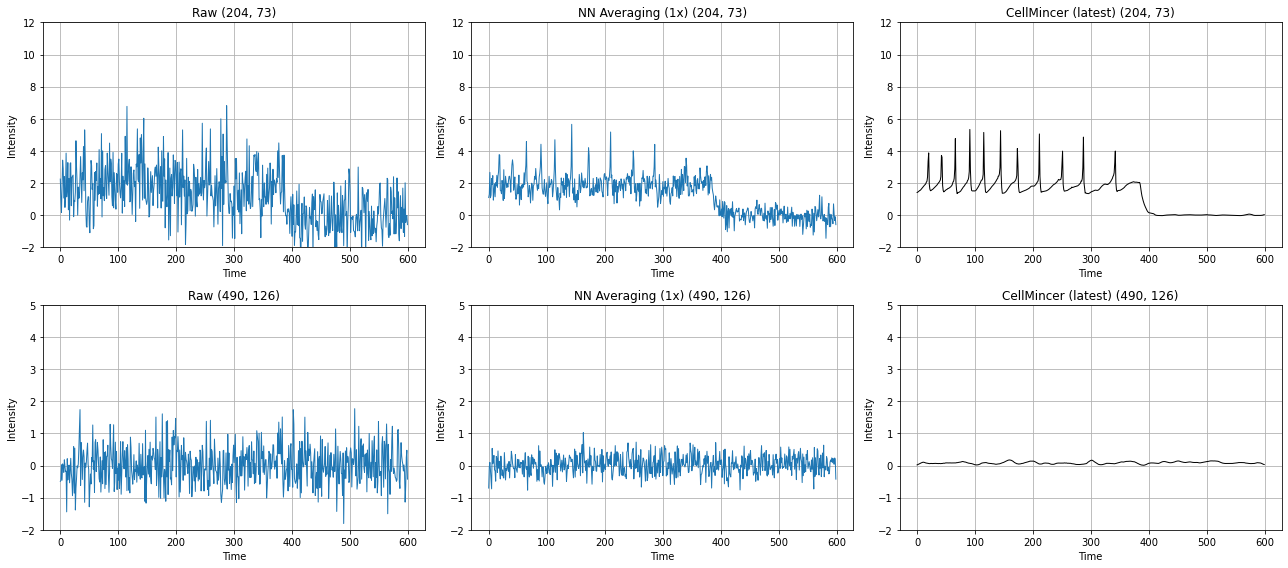

In [17]:
if post_eval:
    ncols = 5
else:
    ncols = 3

fig, axs = plt.subplots(ncols=ncols, nrows=len(viz_pixels), figsize=(6 * ncols, 4 * len(viz_pixels)))

for i_pixel, (viz_x0, viz_y0) in enumerate(viz_pixels):
    
    pixel_str = f' ({viz_x0}, {viz_y0})'
    axs[i_pixel, 0].plot(raw_movie_txy[:, viz_x0, viz_y0], lw=1)
    axs[i_pixel, 0].set_title('Raw' + pixel_str)
    axs[i_pixel, 0].set_xlabel('Time')
    axs[i_pixel, 0].set_ylabel('Intensity')
    axs[i_pixel, 0].grid()

    axs[i_pixel, 1].plot(nnma_denoised_movie_txy[1:, viz_x0, viz_y0], lw=1)
    axs[i_pixel, 1].set_title(f'NN Averaging ({n_iters_ma}x)' + pixel_str)
    axs[i_pixel, 1].set_xlabel('Time')
    axs[i_pixel, 1].set_ylabel('Intensity')
    axs[i_pixel, 1].grid()

    if post_eval:
        
        for trunc_denoised_movie_pt, label in zip(trunc_denoised_movie_pt_list[:-1], eval_state_labels[:-1]):
            axs[i_pixel, 2].plot(trunc_denoised_movie_pt[i_pixel, :], label=label, lw=1, color='black', alpha=0.05)
            axs[i_pixel, 2].set_title('CellMincer (snapshots)' + pixel_str)
            axs[i_pixel, 2].set_xlabel('Time')
            axs[i_pixel, 2].set_ylabel('Intensity')
        axs[i_pixel, 2].grid()

        axs[i_pixel, 3].plot(trunc_denoised_movie_pt_list[-1][i_pixel, :], label=label, lw=1, color='black')
        axs[i_pixel, 3].set_title('CellMincer (SWA)' + pixel_str)
        axs[i_pixel, 3].set_xlabel('Time')
        axs[i_pixel, 3].set_ylabel('Intensity')
        axs[i_pixel, 3].grid()

        axs[i_pixel, 4].plot(trunc_denoised_movie_sma_pt[i_pixel, :], label=label, lw=1, color='black')
        axs[i_pixel, 4].set_title('CellMincer (SMA)' + pixel_str)
        axs[i_pixel, 4].set_xlabel('Time')
        axs[i_pixel, 4].set_ylabel('Intensity')
        axs[i_pixel, 4].grid()
        
    else:
        
        axs[i_pixel, 2].plot(denoised_movie_txy_list[-1][:, viz_x0, viz_y0], lw=1, color='black')
        axs[i_pixel, 2].set_title('CellMincer (latest)' + pixel_str)
        axs[i_pixel, 2].set_xlabel('Time')
        axs[i_pixel, 2].set_ylabel('Intensity')
        axs[i_pixel, 2].grid()

ylim_list = [(-2, 12), (-2, 5)]
for i_pixel in range(len(viz_pixels)):
    for i_col in range(ncols):
        axs[i_pixel, i_col].set_ylim(ylim_list[i_pixel])

# # lock y limits for each viz pixel
# for i_pixel in range(len(viz_pixels)):
#     min_y_lim = np.inf
#     max_y_lim = -np.inf
#     for i_col in range(ncols):
#         ylim = axs[i_pixel, i_col].get_ylim()
#         min_y_lim = min(min_y_lim, ylim[0])
#         max_y_lim = max(max_y_lim, ylim[1])
#     for i_col in range(ncols):
#         axs[i_pixel, i_col].set_ylim((min_y_lim, max_y_lim))

plt.tight_layout()
plt.savefig(f'./out/{opto_mov_prefixes[i_dataset_denoising]}_{model_prefix}.pdf')

In [ ]:
viz_i_t = 350

fig, ax = new_fig()
im = ax.imshow(denoised_movie_txy[viz_i_t, ...].T, origin='lower')
for (viz_x0, viz_y0) in viz_pixels:
    ax.plot([viz_x0], [viz_y0], marker='.', markersize=16, color='red')
plt.tight_layout()
# plt.savefig(f'./out/{opto_mov_prefixes[i_dataset_denoising]}_{model_prefix}_denoised_snapshot.pdf')

fig, ax = new_fig()
im = ax.imshow(raw_movie_txy[viz_i_t, ...].T, origin='lower')
for (viz_x0, viz_y0) in viz_pixels:
    ax.plot([viz_x0], [viz_y0], marker='.', markersize=16, color='red')
plt.tight_layout()
# plt.savefig(f'./out/{opto_mov_prefixes[i_dataset_denoising]}_{model_prefix}_raw_snapshot.pdf')

fig, ax = new_fig()
im = ax.imshow(ws_base_diff_list[i_dataset_denoising].movie_t_corr_xy.T, origin='lower')
for (viz_x0, viz_y0) in viz_pixels:
    ax.plot([viz_x0], [viz_y0], marker='.', markersize=16, color='red')
plt.tight_layout()
# plt.savefig(f'./out/{opto_mov_prefixes[i_dataset_denoising]}_{model_prefix}_corr.pdf')

## Visualize the learning dynamics

(deprecated)

In [ ]:
%matplotlib inline

import matplotlib.animation as animation
import time as time

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
i_pixel = 0

def update_frame(snapshot_index):
    snapshot_i_iter = (model_averaging_begin_index + model_snapshot_stride * snapshot_index) * save_every
    axs[0].clear()
    axs[0].scatter(np.arange(len(total_loss_hist)), total_loss_hist, s=1, alpha=0.5)
    axs[0].plot([snapshot_i_iter, snapshot_i_iter], [0.5, 0.8], lw=2, color='red')
    axs[1].clear()
    axs[1].plot(trunc_denoised_movie_pt_list[snapshot_index][i_pixel, :], lw=1, color='black')
    
    axs[0].set_ylim((0.5, 0.8))
    axs[0].set_xlim((0, len(total_loss_hist)))
    axs[0].set_ylabel('Loss (per pixel)', fontsize=16)
    axs[0].set_xlabel('Iteration', fontsize=16)

    axs[1].set_ylim((-0.5, 10.))
    axs[1].set_xlim((0, 600))
    axs[1].set_ylabel('Denoised intensity', fontsize=16)
    axs[1].set_xlabel('Time', fontsize=16)

    fig.tight_layout()


update_frame(0)
ani = animation.FuncAnimation(fig, update_frame, len(trunc_denoised_movie_pt_list))
writer = animation.writers['ffmpeg'](fps=30)
ani.save('demo.mp4', writer=writer, dpi=100)

## Generate denoised datasets

In [16]:
from time import time

for i_dataset in trange(n_datasets):

    t_mid = (denoiser_config['t_order'] - 1) // 2
    denoised_movie_txy = np.zeros_like(ws_base_diff_list[i_dataset].movie_txy)
    log_frequency = 500
    total_frames = ws_base_diff_list[i_dataset].n_frames - t_mid
    t0 = time()

    frame_pbar = tqdm(range(t_mid, total_frames))
    
    for i_t in frame_pbar:

        denoising_input_data = generate_input_for_single_frame_denoising(
            ws_denoising_list=ws_denoising_list,
            i_dataset=i_dataset,
            i_t=i_t,
            t_order=denoiser_config['t_order'],
            x0=0,
            y0=0,
            x_window=ws_base_diff_list[i_dataset].width,
            y_window=ws_base_diff_list[i_dataset].height,
            device=device,
            dtype=dtype)

        denoised_frame_xy = denoise_single_frame(
            denoising_input_data,
            ws_denoising_list=ws_denoising_list,
            spatial_unet_processor=spatial_unet_processor,
            temporal_denoiser=temporal_denoiser)['temporal_endpoint_xy']

        denoised_movie_txy[i_t, ...] = denoised_frame_xy.cpu().numpy()

#         if (i_t - t_mid) % log_frequency == 0 and i_t > t_mid:
#             fps = log_frequency / (time() - t0)
#             t0 = time()
#             print(f'[{opto_mov_prefixes[i_dataset]}] processed {i_t - t_mid}/{total_frames} frames ({fps:.3} fps)...')

    denoised_movie_txy[:t_mid, ...] = denoised_movie_txy[t_mid, ...]
    denoised_movie_txy[total_frames:, ...] = denoised_movie_txy[total_frames - 1, ...]
    
    denoised_movie_txy *= ws_denoising_list[i_dataset].cached_features.norm_scale
    denoised_movie_txy += ws_base_bg_list[i_dataset].movie_txy

    np.save(
        os.path.join(
            output_path,
            opto_mov_prefixes[i_dataset] + "__" + model_prefix + "__denoised.npy"),
        denoised_movie_txy.transpose(0, 2, 1))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6288 [00:00<?, ?it/s]

In [6]:
os.path.join(
            output_path,
            opto_mov_prefixes[0] + "__" + model_prefix + "__denoised.npy")

'/home/jupyter/bw-data/Optosynth/denoised-data/optosynth_first_wave__1__20__50__optosynth-1-20-50__denoised.npy'

## Analysis

In [49]:
from matplotlib.colors import Normalize

i_dataset = 0

denoised_movie_txy = np.load(
        os.path.join(
            output_path,
            opto_mov_prefixes[i_dataset] + "__" + model_prefix + "__denoised.npy")).transpose(0, 2, 1)

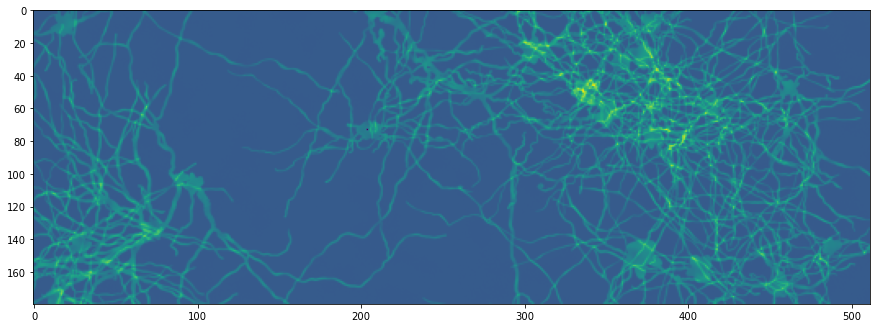

In [51]:
pix = (204, 73)

frame = denoised_movie_txy[1200].copy()
frame[pix] = 0

plt.figure(figsize=(15, 12))
plt.imshow(frame.T)
plt.show()

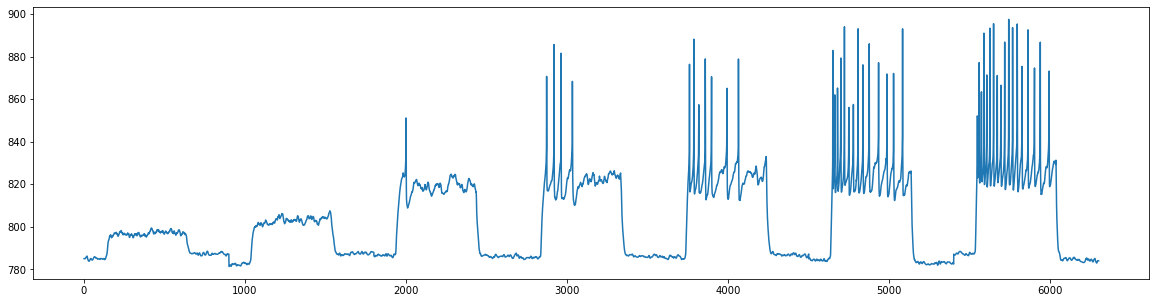

In [54]:
plt.figure(figsize=(20, 5))
plt.plot(np.arange(len(denoised_movie_txy)), denoised_movie_txy[:, pix[0], pix[1]])
plt.show()

## Make movies

In [17]:
import skvideo
from skvideo import io as skio
from matplotlib.colors import Normalize

max_pixel_value = 255

def normalize_movie(
    movie_txy: np.ndarray,
    n_sigmas: float):
    z_movie_txy  = (movie_txy - movie_txy.mean(axis=0)) / movie_txy.std(axis=0)
    norm = Normalize(vmin=0, vmax=n_sigmas, clip=True)
    return max_pixel_value * norm(z_movie_txy)[..., None]


'''
Returns an array of PSNR values with shape (T,)
'''
def psnr(
    clean: np.ndarray,
    noisy: np.ndarray,
    peak: int):
    
    assert clean.shape == noisy.shape, f'{clean.shape} != {noisy.shape}'
    mse = np.mean(np.square(clean - noisy), axis=tuple(range(1, clean.ndim)))
    psnr = 10 * np.log10(peak * peak / mse)
    
    return psnr

def trim_segments(movie_txy, len_segment, trim):
    return np.concatenate([movie_txy[i + trim:i + len_segment - trim] for i in range(0, len(movie_txy), len_segment)])

In [18]:
for i_dataset in range(1):
    # write denoised movie
    denoised_movie_txy = np.load(
        os.path.join(
            output_path,
            opto_mov_prefixes[i_dataset] + "__" + model_prefix + "__denoised.npy")).transpose(0, 2, 1)
    
    
    if data_source == 'optosynth':
        clean_movie_txy = np.load(
            os.path.join(
                data_dir, 'data', opto_mov_prefixes[i_dataset], 'clean_movie_tyx.npz'))['arr_0'].transpose(0, 2, 1)
        
        clean_movie_trim_txy = trim_segments(clean_movie_txy, 1000, 50)
        
        psnr_t = psnr(clean_movie_trim_txy, denoised_movie_txy, peak = 2 ** 16 - 1)

        print(f'dataset {i_dataset} psnr -- mean: {np.mean(psnr_t):.4f}, std: {np.std(psnr_t):.4f}')
        
    denoised_movie_norm_txy = normalize_movie(denoised_movie_txy, n_sigmas = 5)

    movie_out_path = os.path.join(
        output_path,
        opto_mov_prefixes[i_dataset] + "__" + model_prefix + "__denoised.avi")

    writer = skio.FFmpegWriter(
        movie_out_path,
        outputdict={'-vcodec': 'rawvideo', '-pix_fmt': 'yuv420p', '-r': '60'})

    for frame in denoised_movie_norm_txy[4500:5500]:
        writer.writeFrame(frame.T)
    writer.close()
    
    # upload first denoised movie to neptune
#     if i_dataset == 0:
#         run['denoised_example'].upload(movie_out_path)

dataset 0 psnr -- mean: 87.8017, std: 4.3433


In [19]:
os.path.join(
        output_path,
        opto_mov_prefixes[i_dataset] + "__" + model_prefix + "__denoised.avi")

'/home/jupyter/bw-data/Optosynth/denoised-data/optosynth_first_wave__1__20__50__optosynth-1-20-50-L2__denoised.avi'

In [57]:
print('clean', clean_movie_txy.min(), clean_movie_txy.max())
print('denoised', denoised_movie_txy.min(), denoised_movie_txy.max())
print(ws_base_diff_list[i_dataset].movie_txy.min(), ws_base_diff_list[i_dataset].movie_txy.max())
print(ws_base_bg_list[i_dataset].movie_txy.min(), ws_base_bg_list[i_dataset].movie_txy.max())
print(ws_denoising_list[i_dataset].cached_features.norm_scale)

clean 524.3222 1778.8989
denoised 522.32275 1771.7601
-206.78815 348.87488
523.0097 1729.0619
21.178215


In [16]:
# write raw movie
for i_dataset in range(n_datasets):
    movie_out_path = os.path.join(
        output_path,
        opto_mov_prefixes[i_dataset] + '_raw.avi')

    writer = skvideo.io.FFmpegWriter(
        movie_out_path,
        outputdict={'-vcodec': 'rawvideo', '-pix_fmt': 'yuv420p', '-r': '60'})

    for i in range(4350, 4800):
        writer.writeFrame(ws_base_diff_list[i_dataset].movie_txy[i, ...].T)
    writer.close()
#     if i_dataset == 0:
#         run['raw_example'].upload(movie_out_path)

In [17]:
# ground truth movie, optosynth only
if data_source == 'optosynth':
    for i_dataset in range(n_datasets):
        # write ground truth movie
        truth_movie_txy = np.load(
            os.path.join(
                data_dir,
                opto_mov_prefixes[i_dataset], "clean_movie_tyx.npz"))['arr_0'].transpose(0, 2, 1)

        truth_movie_txy = normalize_movie(truth_movie_txy)

        movie_out_path = os.path.join(
            output_path,
            opto_mov_prefixes[i_dataset] + "__" + model_prefix + "__gt.avi")

        writer = skio.FFmpegWriter(
            movie_out_path,
            outputdict={'-vcodec': 'rawvideo', '-pix_fmt': 'yuv420p', '-r': '60'})

        for i in range(4200, 4900):
            writer.writeFrame(truth_movie_txy[i, ...].T)
        writer.close()

(7000, 512, 180)
(7000, 512, 180)


## PSNR on denoised data (deprecated; don't run)

In [ ]:
# def psnr_t_mean(
#     data1: np.ndarray,
#     data2: np.ndarray,
#     peak: int):
    
#     assert data1.shape == data2.shape
#     mse = np.mean(np.square(data1 - data2))
#     mean_psnr = 20 * np.log10(peak) - 10 * np.log10(mse)
    
#     return mean_psnr
    

# model_prefix_1 = 'full-seed0'
# model_prefix_2 = 'dataset0-seed0'

# for i_dataset in tqdm(range(n_datasets)):
#     denoised_movie_txy_1 = normalize_movie(
#         np.load(
#             os.path.join(
#                 output_path,
#                 opto_mov_prefixes[i_dataset] + "__" + model_prefix_1 + "__denoised.npy")).transpose(0, 2, 1))

#     denoised_movie_txy_2 = normalize_movie(
#         np.load(
#             os.path.join(
#                 output_path,
#                 opto_mov_prefixes[i_dataset] + "__" + model_prefix_2 + "__denoised.npy")).transpose(0, 2, 1))

#     mean_psnr = psnr_t_mean(denoised_movie_txy_1, denoised_movie_txy_2, max_pixel_value)
#     print(f'dataset {i_dataset}: PSNR = {mean_psnr:.4f}')

## Play movie

In [ ]:
# # broken, do not run if you like having a functional VM

# from ipywebrtc import VideoStream

# model_prefix = 'full-seed0'

# i_dataset = 0
# movie_path = os.path.join(
#         output_path,
#         opto_mov_prefixes[i_dataset] + "__" + model_prefix + "__denoised.avi")

# movie = VideoStream.from_file(movie_path)
# movie